In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
from scipy.linalg import fractional_matrix_power
from dataclasses import dataclass
from typing import Protocol, Any
from sklearn.linear_model import LinearRegression
import math
from copulas.bivariate import Bivariate, CopulaTypes
from sklearn.linear_model import ElasticNet
from pycop import archimedean, estimation
from pycop import mixture
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy import stats
from scipy import signal

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''helper functions for the copula fitting'''
def mixed_copula_fitting(training_data, cop_types):
    cop = mixture(cop_types)
    try:
        param, mle = estimation.fit_cmle_mixt(cop, training_data)
    except:
        try:
            param, mle = estimation.fit_cmle_mixt(cop, training_data, opti_method='trust-constr')
        except:
            print('Fitting failed')
            return [0 for i in range(len(cop_types)*2)]
    if len(cop_types) == 2:
        return [param[0],1-param[0], param[1], param[2]]
    return param
    # calculate the rolling volatility of the asset returns

def rolling_volatility(asset, window):
    # calculate the log returns
    log_ret = np.log(asset['Close']).diff()
    # calculate the rolling volatility
    rolling_vol = log_ret.rolling(window).std() * np.sqrt(window)
    return pd.DataFrame(rolling_vol)

def mispricing_index(ecdf1, ecdf2, ret1, ret2, cop_type, n, theta):
    u = ecdf1(ret1)*n/(n+1)
    v = ecdf2(ret2)*n/(n+1)
    # check if u or v is 0 or 1
    if u == 0:
        u = 1e-10
    elif u == 1:
        u = 1 - 1e-10
    if v == 0:
        v = 1e-10
    elif v == 1:
        v = 1 - 1e-10
    if cop_type == 'clayton':
            MI_u_v = v ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(U<u|V=v)
            MI_v_u = u ** (-theta - 1) * (u ** (-theta) + v ** (-theta) - 1) ** (-1 / theta - 1) # P(V<v|U=u)
    
    elif cop_type == 'frank':
        A = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * v) - 1)
        B = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta * u) - 1)
        C = (np.exp(-theta * u) - 1) * (np.exp(-theta * v) - 1) + (np.exp(-theta) - 1)
        MI_u_v = B / C
        MI_v_u = A / C
    
    elif cop_type == 'gumbel':
        A = (-np.log(u)) ** theta + (-np.log(v)) ** theta
        C_uv = np.exp(-A ** (1 / theta))   # C_uv is gumbel copula function C(u,v)
        MI_u_v = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(v)) ** (theta - 1) * (1.0 / v)
        MI_v_u = C_uv * (A ** ((1 - theta) / theta)) * (-np.log(u)) ** (theta - 1) * (1.0 / u)
    return  MI_u_v, MI_v_u

# check if the data is cointegrated
def EG_method(X,Y,show_summary=False):
    
    #step 1
    #estimate long run equilibrium
    model1=sm.OLS(Y,sm.add_constant(X)).fit()
    epsilon=model1.resid
    
    if show_summary:
        print('\nStep 1\n')
        print(model1.summary())
    
    #check p value of augmented dickey fuller test
    #if p value is no larger than 5%, stationary test is passed
    if sm.tsa.stattools.adfuller(epsilon)[1]>0.05:
        return False,model1
    
    #take first order difference of X and Y plus the lagged residual from step 1
    X_dif=sm.add_constant(pd.concat([X.diff(),epsilon.shift(1)],axis=1).dropna())
    Y_dif=Y.diff().dropna()        
    
    #step 2
    #estimate error correction model
    model2=sm.OLS(Y_dif,X_dif).fit()
    
    if show_summary:
        print('\nStep 2\n')
        print(model2.summary())
    
    #adjustment coefficient must be negative
    if list(model2.params)[-1]>0:
        return False,model1
    else:
        return True,model1

def half_life(ts):  
    """ 
    Calculates the half life of a mean reversion
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # delta = p(t) - p(t-1)
    delta_ts = np.diff(ts)
    
    # calculate the vector of lagged values. lag = 1
    lag_ts = np.vstack([ts[1:], np.ones(len(ts[1:]))]).T
   
    # calculate the slope of the deltas vs the lagged values 
    beta = np.linalg.lstsq(lag_ts, delta_ts)
    
    # compute and return half life
    return (np.log(2) / beta[0])[0]
    
def get_hurst_exponent(time_series, max_lag=20):
    """
    Returns the Hurst Exponent of the time series
    """
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]
#  calculate the mean crossing rate
def mean_crossing_rate(asset, window):
    # calculate the log returns
    log_ret = np.log(asset).diff()
    # calculate the rolling mean
    rolling_mean = log_ret.rolling(window).mean()
    # calculate the mean crossing rate
    mcr = np.where(log_ret > rolling_mean, 1, 0).sum() / window
    return mcr
# calculate the kendall's tau
def kendall_tau(series, df_returns, start_checking, end_checking):
    asset_name_1 = series.name[0]
    asset_name_2 = series.name[1]
    # calculate the log returns
    log_ret_1 = df_returns[asset_name_1].loc[start_checking:end_checking]
    log_ret_2 = df_returns[asset_name_2].loc[start_checking:end_checking]
    # calculate the kendall's tau
    tau, p_value = stats.kendalltau(log_ret_1, log_ret_2)
    return tau

# given a series, calculate the LTDC
def LTDC_series(series, cop_type):
    theta = series.loc['param_{}'.format(cop_type)]
    index = cop_types.index(cop_type)
    # calculate the LTCD
    cop_ = archimedean(family=cop_type)
    LTDC_ = cop_.LTDC(theta)
    return LTDC_

def UTDC_series(series, cop_type):
    theta = series.loc['param_{}'.format(cop_type)]
    index = cop_types.index(cop_type)
    # calculate the UTCD
    cop_ = archimedean(family=cop_type)
    UTDC_ = cop_.UTDC(theta)
    return UTDC_

def mixed_UTDC_series(series):
    UTDC_mixed = 0
    for cop_type in cop_types:
        w = series.loc['w_{}'.format(cop_type)]
        UTDC_mixed += series.loc['UTDC_{}'.format(cop_type)] * w
    return UTDC_mixed

def mixed_LTDC_series(series):
    LTDC_mixed = 0
    for cop_type in cop_types:
        w = series.loc['w_{}'.format(cop_type)]
        LTDC_mixed += series.loc['LTDC_{}'.format(cop_type)] * w
    return LTDC_mixed



In [3]:
"""Box-Tiao Canonical Decomposition."""

# ------------------------------------------------------------------------------
# Regression Model Interface


class RegressionModel(Protocol):
    """
    Regression model interface.
    Sklearn regression model compliant.
    """

    def fit(self, X: np.ndarray, y: np.ndarray) -> Any:
        """
        Fit model to X and y.
        Sklearn Regression model compliant.
        - X is a numpy 2D array of shape (n_samples, n_features)
        - y is a numpy 1D array of shape (n_samples,)
        """

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Model prediction method.
        - X is a numpy 2D array of shape (n_samples, n_features)
        returns a 1D array of shape (X.shape[0],).
        """


# ------------------------------------------------------------------------------
# Decomposition Public


@dataclass
class CanDecompSolution:
    lambdas: np.ndarray  # 1D array, lambdas are indexed in ascending order.
    w_vecs: np.ndarray  # 2D array, columns are indexed as lambdas.


def decompose(
    p_mat: np.ndarray, regression_model: RegressionModel, max_lag: int = 5
) -> CanDecompSolution:
    """
    All canonical decomposition steps, calculate final answer.
    p_mat is of shape(t,n), i.e. each column is a time series.
    """
    B_sqrt_inv = _get_B_sqrt_inv(p_mat)
    A = _get_A(p_mat, regression_model, max_lag=max_lag)
    D = np.matmul(np.matmul(B_sqrt_inv, A), B_sqrt_inv)
    eigen_solution = _get_eigensolution(D)
    return CanDecompSolution(
        lambdas=eigen_solution.eigval, 
        w_vecs=np.matmul(B_sqrt_inv, eigen_solution.eigvec)
    )


# ------------------------------------------------------------------------------
# Private


def _get_expected_dyadic_prod(V: np.ndarray) -> np.ndarray:
    """
    Returns E[v^T v] for dim(v) = n and t observations.
    V shape is (t, n).
    """
    return (1.0 / V.shape[0]) * np.matmul(V.T, V)


# ---------------------------------------------------
# B


def _get_B(p_mat: np.ndarray) -> np.ndarray:
    """Rows of p_mat represent t index, columns represent each path."""
    return _get_expected_dyadic_prod(p_mat)


def _get_mat_sqrt(V: np.ndarray) -> np.ndarray:
    """Square root of matrix V."""
    return fractional_matrix_power(V, 0.5)


def _get_inv_mat(mat: np.ndarray) -> np.ndarray:
    """Matrix inverse."""
    return np.linalg.inv(mat)


def _get_B_sqrt_inv(p_mat: np.ndarray) -> np.ndarray:
    """Rows of p_mat represent t index, columns represent each path."""
    B = _get_B(p_mat)
    B_sqrt = _get_mat_sqrt(B)
    return _get_inv_mat(B_sqrt)


# ---------------------------------------------------
# A


def _get_X(p_mat: np.ndarray, max_lag: int) -> np.ndarray:
    """
    Lags the columns of p_mat into the feature array X.
    Returns a 2D array of (T-max_lag, n_features)
    - p_mat is of shape (T-max_lag, n)
    * n_features = max_lag * n.
    """
    return np.concatenate(
        [p_mat[max_lag - lag : -lag, :] for lag in range(1, max_lag + 1)], axis=1
    )


def _get_y(p_mat: np.ndarray, p_mat_col_idx: int, max_lag: int) -> np.ndarray:
    """
    Returns a 1D array which corresonds to a specific column of p_mat,
    with the first max_lag idxs trimmed.
    the index of this column is p_mat_col_idx
    """
    return p_mat[max_lag:, p_mat_col_idx]


def _get_q_t(
    regression_model: RegressionModel, X: np.ndarray, y: np.ndarray
) -> np.ndarray:
    """
    Expected value for p_t (q model) using RegressionModel.
    - X is a numpy 2D array of shape (T-max_lag, n_features)
    - y is a numpy 1D array of shape (T-max_lag,)
    """
    regression_model.fit(X, y)
    return regression_model.predict(X)


def _get_A(
    p_mat: np.ndarray, regression_model: RegressionModel, max_lag: int = 1
) -> np.ndarray:
    """Estimate A using an instance of RegressionModel."""
    X = _get_X(p_mat, max_lag)
    qs = []
    # model each column j of p_mat.
    for j in range(p_mat.shape[1]):
        y = _get_y(p_mat, j, max_lag)
        q_j = _get_q_t(regression_model, X, y)
        qs.append(q_j)
    q_mat = np.asarray(qs).T
    return _get_expected_dyadic_prod(q_mat)

# ---------------------------------------------------
# Eigensolution


@dataclass
class _EigenSolution:
    eigval: np.ndarray  # 1D array, eigen values indexed in ascending order.
    eigvec: np.ndarray  # 2D array, columns are indexed as eigval.


def _get_eigensolution(mat: np.ndarray) -> _EigenSolution:
    eigenvalues, eigenvectors = np.linalg.eigh(mat)
    return _EigenSolution(eigval=eigenvalues, eigvec=eigenvectors)

# ------------------------------------------------------------------------------
# get spread
def get_St(w_vec: np.ndarray, p_mat: np.ndarray, index) -> np.ndarray:
    return pd.DataFrame( np.dot(w_vec, p_mat.T),index = index)

In [4]:
'''pair selection'''
# get data
indices = pd.read_excel('indices.xlsx', index_col=0)
indices = indices[(indices['class'] == 'major_indices') | (indices['class'] == 'additional_indices')].drop_duplicates(subset=['symbol'])

# replace the "^SPX" with "GSPC"
indices['symbol'] = indices['symbol'].replace('^SPX', '^GSPC')
indices = indices['symbol'].tolist()
# remove the failed indices(^TRX50USP, ^MIUS00000PUS, ^MIUS00000NEU, ^OTCDR, ^OTCQX30, ^RUMNU, ^MIUS00000NUS)
indices = [x for x in indices if x not in ['^TRX50USP', '^MIUS00000PUS', '^MIUS00000NEU', '^OTCDR', '^OTCQX30', '^RUMNU', '^MIUS00000NUS']]
indices.sort()
# download data
start = '2016-01-01'
end = '2023-01-01'
df_closes = yf.download(indices, start=start, end=end)
df_closes = df_closes['Adj Close']

[*********************100%***********************]  12 of 12 completed


In [5]:
'''compute the features'''
# get returns
df_returns = df_closes.pct_change().dropna()
# create the pairs
pairs = []
for i in range(len(indices)):
    for j in range(i+1, len(indices)):
        pairs.append((indices[i], indices[j]))
# set checking period
start_checking = '2016-01-01'
end_checking = '2018-01-01'
# check if the pairs are cointegrated
cointegrated_pairs = []
for pair in pairs:
    X = df_closes.loc[start_checking:end_checking, pair[0]]
    Y = df_closes.loc[start_checking:end_checking, pair[1]]
    if_cointegrated, model = EG_method(X,Y,show_summary=False)
    if if_cointegrated:
        cointegrated_pairs.append(pair)
# construct the pairs dataframe, the columns are the pairs, the index are the checking period
df_pairs = pd.DataFrame(index=df_closes.loc[start_checking:end_checking].index, columns=pairs)
# 
# calculate the spread using box-tiao
for pair in pairs:
    close1 = df_closes.loc[start_checking:end_checking, pair[0]]
    close2 = df_closes.loc[start_checking:end_checking, pair[1]]
    # combine the two series
    p_mat = np.array([close1, close2]).T
    # p_mat = np.array([df_closes.loc[start_checking:end_checking, pair[0]], df_closes.loc[start_checking:end_checking, pair[1]]]).T
    can_decomp_solution = decompose(p_mat, regression_model = ElasticNet(), max_lag=1)
    w_vec = can_decomp_solution.w_vecs[:,0]
    df_pairs[pair] = np.dot(w_vec, p_mat.T)
# calculate the hurst exponent
df_hurst = df_pairs.apply(lambda x: get_hurst_exponent(x.values, max_lag=30), axis=0)
# calculate the half life
df_halflife = df_pairs.apply(lambda x: half_life(x.values), axis=0)
# calculate the mean_crossing
df_mean_crossing = df_pairs.apply(lambda x: mean_crossing_rate(x,window=30), axis=0)
# calculate the kendall tau
df_kendall = df_pairs.apply(lambda x: kendall_tau(x, df_returns, start_checking, end_checking), axis=0)
not_cointegrated_pairs = [x for x in pairs if x not in cointegrated_pairs]

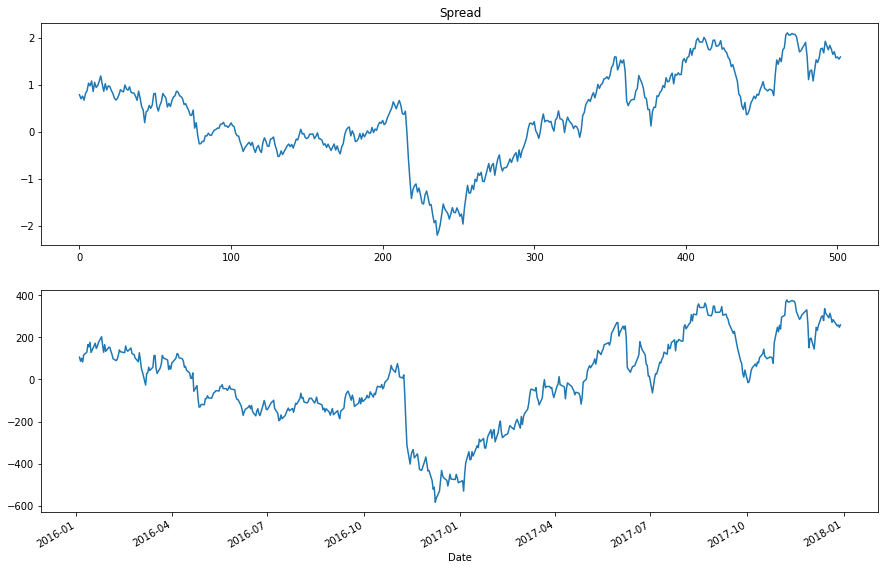

In [6]:
'''visualize the spread'''
# 
close1 = df_closes.loc[start_checking:end_checking, '^IXIC']
close2 = df_closes.loc[start_checking:end_checking, '^RUT']
# two axis
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
# plot the two series
# combine the two series
p_mat = np.array([close1, close2]).T
# p_mat = np.array([df_closes.loc[start_checking:end_checking, pair[0]], df_closes.loc[start_checking:end_checking, pair[1]]]).T
can_decomp_solution = decompose(p_mat, regression_model = ElasticNet(), max_lag=10)
w_vec = can_decomp_solution.w_vecs[:,0]
spread_box = pd.Series(np.dot(w_vec, p_mat.T))
spread_box.plot(ax=ax[0])
ax[0].set_title('Spread')
# run the ols regression(no constant) and get the residuals
model = sm.OLS(close1, close2, has_constant= False)
results = model.fit()
residuals = results.resid
# plot the residuals
residuals.plot(ax=ax[1])
# get the model parameters
params = results.params

In [30]:
spread_box.index = df_closes.loc[start_checking:end_checking].index
# no time zone
spread_box.index = spread_box.index.tz_localize(None)
spread_box.to_excel('data/spread_box.xlsx')

In [7]:
df_kendall.loc[cointegrated_pairs].sort_values( ascending=False)

(^GSPC, ^OEX)    0.874021
(^GSPC, ^NYA)    0.793528
(^DJA, ^DJI)     0.748503
(^NYA, ^OEX)     0.716599
(^DJA, ^GSPC)    0.711000
(^DJA, ^NYA)     0.703271
(^DJA, ^OEX)     0.661808
(^IXIC, ^NYA)    0.575272
(^DJA, ^IXIC)    0.518127
(^DJA, ^NDX)     0.470000
(^DJU, ^XAX)     0.164969
(^DJI, ^DJU)     0.137470
(^DJU, ^VIX)    -0.140746
(^VIX, ^XAX)    -0.291695
(^DJT, ^VIX)    -0.378629
(^RUT, ^VIX)    -0.464911
(^DJA, ^VIX)    -0.467980
(^DJI, ^VIX)    -0.476966
(^NDX, ^VIX)    -0.487925
(^NYA, ^VIX)    -0.503654
(^IXIC, ^VIX)   -0.517411
(^OEX, ^VIX)    -0.542795
(^GSPC, ^VIX)   -0.553180
dtype: float64

In [8]:
df_kendall.loc[not_cointegrated_pairs].sort_values( ascending=False)

(^IXIC, ^NDX)     0.856478
(^DJI, ^OEX)      0.766634
(^DJI, ^GSPC)     0.765314
(^DJI, ^NYA)      0.728288
(^GSPC, ^IXIC)    0.717617
(^IXIC, ^OEX)     0.707454
(^DJA, ^DJT)      0.694666
(^NDX, ^OEX)      0.679907
(^NYA, ^RUT)      0.669347
(^GSPC, ^NDX)     0.654667
(^GSPC, ^RUT)     0.642500
(^IXIC, ^RUT)     0.614906
(^OEX, ^RUT)      0.566365
(^DJT, ^NYA)      0.564648
(^DJA, ^RUT)      0.562230
(^DJI, ^RUT)      0.560719
(^DJI, ^IXIC)     0.560671
(^DJT, ^GSPC)     0.550047
(^DJI, ^DJT)      0.534747
(^DJT, ^RUT)      0.532298
(^DJI, ^NDX)      0.516139
(^DJT, ^OEX)      0.493761
(^NDX, ^NYA)      0.491487
(^NDX, ^RUT)      0.479527
(^NYA, ^XAX)      0.459265
(^DJT, ^IXIC)     0.447416
(^GSPC, ^XAX)     0.399814
(^OEX, ^XAX)      0.384434
(^DJT, ^NDX)      0.379631
(^DJI, ^XAX)      0.362725
(^DJA, ^XAX)      0.361723
(^RUT, ^XAX)      0.357922
(^IXIC, ^XAX)     0.341238
(^NDX, ^XAX)      0.318399
(^DJT, ^XAX)      0.277747
(^DJA, ^DJU)      0.254066
(^DJU, ^GSPC)     0.151530
(

In [23]:
'''selected_pairs'''
selected_pairs=  df_hurst[(df_halflife < 60) & (df_hurst>0.5) & (df_mean_crossing > 1)]
df_selected = df_kendall[selected_pairs.index].sort_values( ascending=False)
df_selected.to_excel('data/selected_pairs_kendell.xlsx')

In [10]:
'''signal generation function_mc_vix'''
def signal_generation_mc_vix(asset1, asset2, training_window, trading_period, cop_types, boundarys, vix_boundry):    
    # initialize
    df_coef=pd.DataFrame()
    df_coef['asset1']=asset1['Close']
    df_coef['asset2']=asset2['Close']
    df_coef['mpi_1'] = np.nan
    df_coef['mpi_2'] = np.nan
    df_coef['cum_mpi_1'] = np.nan
    df_coef['cum_mpi_2'] = np.nan
    df_coef['signals1'] = np.nan
    df_coef['signals2'] = np.nan
    status_of_position_1 = 0
    for cop_type in cop_types:
        df_coef['w_{}'.format(cop_type)]=np.nan
        df_coef['param_{}'.format(cop_type)]=np.nan
    # calculate log returns
    df_coef['asset1_ret']= np.log(df_coef['asset1']/df_coef['asset1'].shift(1))
    df_coef['asset2_ret']= np.log(df_coef['asset2']/df_coef['asset2'].shift(1))
    # calculate the rolling volatility
    df_coef['asset1_vol']=df_coef['asset1_ret'].rolling(training_window-1).std()
    df_coef['asset2_vol']=df_coef['asset2_ret'].rolling(training_window-1).std()
    # calculate the average volatility percent change
    df_coef['asset1_vol_change']=df_coef['asset1_vol'].pct_change()
    df_coef['asset2_vol_change']=df_coef['asset2_vol'].pct_change()
    df_coef['vol_change'] = (df_coef['asset1_vol_change'] + df_coef['asset2_vol_change'])/2
    df_coef['VIX'] = df_closes['^VIX'].loc[df_coef.index]

    # fit the mixed copula model
    refitting_index = [i for i in range(training_window,len(df_coef)-1,trading_period)]
    for i in range(training_window,len(df_coef)-1):
        # if the index is in the refitting index, we need to refit the model
        # if i in refitting_index or abs(df_coef['vol_change'].iloc[i])>0.1:
        if i in refitting_index or df_coef['VIX'].iloc[i]>35:
            training_data = df_coef[['asset1_ret','asset2_ret']].iloc[i-training_window:i].dropna()
            training_data = training_data.T.values
            n = len(training_data[0])
            ecdf1 = ECDF(training_data[0])
            ecdf2 = ECDF(training_data[1])
            print('refitting the model at index {}'.format(i))
            param = mixed_copula_fitting(training_data, cop_types)
            # resotre the parameters
            for j in range(len(cop_types)):
                cop_type = cop_types[j]
                df_coef['w_{}'.format(cop_type)].iloc[i]=param[j] 
                df_coef['param_{}'.format(cop_type)].iloc[i]=param[j+len(cop_types)]
        # during the trading period, we use the latest parameters to generate the signals
        else :
            for j in range(len(cop_types)):
                cop_type = cop_types[j]
                df_coef['w_{}'.format(cop_type)].iloc[i] = df_coef['w_{}'.format(cop_type)].iloc[i-1]
                df_coef['param_{}'.format(cop_type)].iloc[i] = df_coef['param_{}'.format(cop_type)].iloc[i-1]
        # calculate the mispricing index, using the mispricing_index function and calculate the weighted average
        MPI_1 = 0
        MPI_2 = 0
        for j in range(len(cop_types)):
            ret1 = df_coef['asset1_ret'].iloc[i]
            ret2 = df_coef['asset2_ret'].iloc[i]
            cop_type = cop_types[j]
            theta = df_coef['param_{}'.format(cop_type)].iloc[i]
            w = df_coef['w_{}'.format(cop_type)].iloc[i]
            MI_u_v, MI_v_u  = mispricing_index(ecdf1, ecdf2, ret1, ret2, cop_type, n, theta)
            MPI_1 += w * MI_u_v
            MPI_2 += w * MI_v_u    
        df_coef['mpi_1'].iloc[i] = MPI_1-0.5
        df_coef['mpi_2'].iloc[i] = MPI_2-0.5
        bound_signal = boundarys[0]
        bound_stop_earn = boundarys[1]
        bound_stop_loss = boundarys[2]

        # calculate the cumulative mispricing index
        if i == training_window:
            df_coef['cum_mpi_1'].iloc[i] = MPI_1-0.5
            df_coef['cum_mpi_2'].iloc[i] = MPI_2-0.5
        else:
            df_coef['cum_mpi_1'].iloc[i] = df_coef['cum_mpi_1'].iloc[i-1] + MPI_1-0.5
            df_coef['cum_mpi_2'].iloc[i] = df_coef['cum_mpi_2'].iloc[i-1] + MPI_2-0.5
        # generate the signals
        # whether to enter the position
        cum_mpi_1 = df_coef['cum_mpi_1'].iloc[i]
        cum_mpi_2 = df_coef['cum_mpi_2'].iloc[i]
        # if reestimate the parameters or the vol is too big, we need to reset the cumulative mispricing index, and close the position
        # if i in refitting_index or abs(df_coef['vol_change'].iloc[i])>0.1:
        if i in refitting_index or df_coef['VIX'].iloc[i]>35:
            df_coef['signals1'].iloc[i] = 0
            status_of_position_1 = 0
            # reset the cumulative mispricing index
            df_coef['cum_mpi_1'].iloc[i] = 0
            df_coef['cum_mpi_2'].iloc[i] = 0
        else:
            if status_of_position_1 == 0:
                if bound_stop_loss> cum_mpi_1 > bound_signal and  -bound_signal>cum_mpi_2>-bound_stop_loss :
                    df_coef['signals1'].iloc[i] = -1
                    status_of_position_1 = -1
                elif bound_stop_loss> cum_mpi_2 > bound_signal and  -bound_signal>cum_mpi_1>-bound_stop_loss:
                    df_coef['signals1'].iloc[i] = 1
                    status_of_position_1 = 1
                else:
                    df_coef['signals1'].iloc[i] = 0
            # whether to exit the position
            elif status_of_position_1 == -1:
                if df_coef['cum_mpi_1'].iloc[i] < bound_stop_earn or df_coef['cum_mpi_2'].iloc[i] > -bound_stop_earn:
                    df_coef['signals1'].iloc[i] = 0
                    status_of_position_1 = 0
                    # reset the cumulative mispricing index
                    df_coef['cum_mpi_1'].iloc[i] = 0
                    df_coef['cum_mpi_2'].iloc[i] = 0
                else:
                    df_coef['signals1'].iloc[i] = -1
            elif status_of_position_1 == 1:
                if df_coef['cum_mpi_2'].iloc[i] < bound_stop_earn or df_coef['cum_mpi_1'].iloc[i] > -bound_stop_earn:
                    df_coef['signals1'].iloc[i] = 0
                    status_of_position_1 = 0
                    # reset the cumulative mispricing index
                    df_coef['cum_mpi_1'].iloc[i] = 0
                    df_coef['cum_mpi_2'].iloc[i] = 0
                else:
                    df_coef['signals1'].iloc[i] = 1

    # generate the signals for asset2
    df_coef['signals2'] = -df_coef['signals1']
    df_coef['positions1']=df_coef['signals1'].diff()
    df_coef['positions2']=df_coef['signals2'].diff()
    return df_coef
        
        




In [11]:
'''signal generation function'''
def signal_generation_mc(asset1, asset2, training_window, trading_period, cop_types, boundarys, training_window_vol):    
    # initialize
    df_coef=pd.DataFrame()
    df_coef['asset1']=asset1['Close']
    df_coef['asset2']=asset2['Close']
    df_coef['mpi_1'] = np.nan
    df_coef['mpi_2'] = np.nan
    df_coef['cum_mpi_1'] = np.nan
    df_coef['cum_mpi_2'] = np.nan
    df_coef['signals1'] = np.nan
    df_coef['signals2'] = np.nan
    status_of_position_1 = 0
    for cop_type in cop_types:
        df_coef['w_{}'.format(cop_type)]=np.nan
        df_coef['param_{}'.format(cop_type)]=np.nan
        df_coef['LTDC_{}'.format(cop_type)]=np.nan
        df_coef['UTDC_{}'.format(cop_type)]=np.nan
    df_coef['mixed_LTDC']=np.nan
    df_coef['mixed_UTDC']=np.nan
    # calculate log returns
    df_coef['asset1_ret']= np.log(df_coef['asset1']/df_coef['asset1'].shift(1))
    df_coef['asset2_ret']= np.log(df_coef['asset2']/df_coef['asset2'].shift(1))
    # calculate the rolling volatility
    df_coef['asset1_vol']=df_coef['asset1_ret'].rolling(training_window-1).std()
    df_coef['asset2_vol']=df_coef['asset2_ret'].rolling(training_window-1).std()
    # calculate the average volatility percent change
    df_coef['asset1_vol_change']=df_coef['asset1_vol'].pct_change()
    df_coef['asset2_vol_change']=df_coef['asset2_vol'].pct_change()
    df_coef['vol_change'] = (df_coef['asset1_vol_change'] + df_coef['asset2_vol_change'])/2

    # fit the mixed copula model
    refitting_index_all = []
    trading_periods_all = []
    refitting_index = [i for i in range(training_window,len(df_coef)-1,trading_period)]
    for i in range(training_window,len(df_coef)-1):
        # if the index is in the refitting index, we need to refit the model
        if i in refitting_index or abs(df_coef['vol_change'].iloc[i])>0.1:
            
            if abs(df_coef['vol_change'].iloc[i])>0.1:
                training_window_actual = training_window_vol
            else:
                training_window_actual = training_window
            training_data = df_coef[['asset1_ret','asset2_ret']].iloc[i-training_window_actual:i].dropna()
            refitting_index_all.append(i)
            trading_periods_all.append((training_data.index))
            training_data = training_data.T.values
            
            n = len(training_data[0])
            ecdf1 = ECDF(training_data[0])
            ecdf2 = ECDF(training_data[1])
            print('refitting the model at index {}'.format(i))
            param = mixed_copula_fitting(training_data, cop_types)
            # resotre the parameters
            for j in range(len(cop_types)):
                cop_type = cop_types[j]
                df_coef['w_{}'.format(cop_type)].iloc[i]=param[j] 
                df_coef['param_{}'.format(cop_type)].iloc[i]=param[j+len(cop_types)]
        # during the trading period, we use the latest parameters to generate the signals
        else :
            for j in range(len(cop_types)):
                cop_type = cop_types[j]
                df_coef['w_{}'.format(cop_type)].iloc[i] = df_coef['w_{}'.format(cop_type)].iloc[i-1]
                df_coef['param_{}'.format(cop_type)].iloc[i] = df_coef['param_{}'.format(cop_type)].iloc[i-1]
        # calculate the mispricing index, using the mispricing_index function and calculate the weighted average
        MPI_1 = 0
        MPI_2 = 0
        for j in range(len(cop_types)):
            ret1 = df_coef['asset1_ret'].iloc[i]
            ret2 = df_coef['asset2_ret'].iloc[i]
            cop_type = cop_types[j]
            theta = df_coef['param_{}'.format(cop_type)].iloc[i]
            w = df_coef['w_{}'.format(cop_type)].iloc[i]
            MI_u_v, MI_v_u  = mispricing_index(ecdf1, ecdf2, ret1, ret2, cop_type, n, theta)
            MPI_1 += w * MI_u_v
            MPI_2 += w * MI_v_u    
        df_coef['mpi_1'].iloc[i] = MPI_1-0.5
        df_coef['mpi_2'].iloc[i] = MPI_2-0.5
        bound_signal = boundarys[0]
        bound_stop_earn = boundarys[1]
        bound_stop_loss = boundarys[2]

        # calculate the cumulative mispricing index
        if i == training_window:
            df_coef['cum_mpi_1'].iloc[i] = MPI_1-0.5
            df_coef['cum_mpi_2'].iloc[i] = MPI_2-0.5
        else:
            df_coef['cum_mpi_1'].iloc[i] = df_coef['cum_mpi_1'].iloc[i-1] + MPI_1-0.5
            df_coef['cum_mpi_2'].iloc[i] = df_coef['cum_mpi_2'].iloc[i-1] + MPI_2-0.5
        # generate the signals
        # whether to enter the position
        cum_mpi_1 = df_coef['cum_mpi_1'].iloc[i]
        cum_mpi_2 = df_coef['cum_mpi_2'].iloc[i]
        # if reestimate the parameters or the vol is too big, we need to reset the cumulative mispricing index, and close the position
        if i in refitting_index or abs(df_coef['vol_change'].iloc[i])>0.1:
            df_coef['signals1'].iloc[i] = 0
            status_of_position_1 = 0
            # reset the cumulative mispricing index
            df_coef['cum_mpi_1'].iloc[i] = 0
            df_coef['cum_mpi_2'].iloc[i] = 0
        else:
            if status_of_position_1 == 0:
                if bound_stop_loss> cum_mpi_1 > bound_signal and  -bound_signal>cum_mpi_2>-bound_stop_loss :
                    df_coef['signals1'].iloc[i] = -1
                    status_of_position_1 = -1
                elif bound_stop_loss> cum_mpi_2 > bound_signal and  -bound_signal>cum_mpi_1>-bound_stop_loss:
                    df_coef['signals1'].iloc[i] = 1
                    status_of_position_1 = 1
                else:
                    df_coef['signals1'].iloc[i] = 0
            # whether to exit the position
            elif status_of_position_1 == -1:
                if df_coef['cum_mpi_1'].iloc[i] < bound_stop_earn or df_coef['cum_mpi_2'].iloc[i] > -bound_stop_earn:
                    df_coef['signals1'].iloc[i] = 0
                    status_of_position_1 = 0
                    # reset the cumulative mispricing index
                    df_coef['cum_mpi_1'].iloc[i] = 0
                    df_coef['cum_mpi_2'].iloc[i] = 0
                else:
                    df_coef['signals1'].iloc[i] = -1
            elif status_of_position_1 == 1:
                if df_coef['cum_mpi_2'].iloc[i] < bound_stop_earn or df_coef['cum_mpi_1'].iloc[i] > -bound_stop_earn:
                    df_coef['signals1'].iloc[i] = 0
                    status_of_position_1 = 0
                    # reset the cumulative mispricing index
                    df_coef['cum_mpi_1'].iloc[i] = 0
                    df_coef['cum_mpi_2'].iloc[i] = 0
                else:
                    df_coef['signals1'].iloc[i] = 1

    # generate the signals for asset2
    df_coef['signals2'] = -df_coef['signals1']
    df_coef['positions1']=df_coef['signals1'].diff()
    df_coef['positions2']=df_coef['signals2'].diff()
    # calculate the LTDC and the UTDC
    for cop_type in cop_types:
        df_coef['LTDC_{}'.format(cop_type)] = df_coef.apply(lambda x: LTDC_series(x,cop_type), axis=1)
        df_coef['UTDC_{}'.format(cop_type)] = df_coef.apply(lambda x: UTDC_series(x,cop_type), axis=1)
    # calculate the mixed LTDC and UTDC
    df_coef['mixed_LTDC'] = df_coef.apply(lambda x: mixed_LTDC_series(x), axis=1)
    df_coef['mixed_UTDC'] = df_coef.apply(lambda x: mixed_UTDC_series(x), axis=1)
    return df_coef, refitting_index_all, trading_periods_all
        
        




In [12]:
'''function to plot the price and positions'''
def plot_price(data,ticker1,ticker2):    
   
    fig=plt.figure(figsize=(10,5))
    bx=fig.add_subplot(111)   
    bx2=bx.twinx()
    
    #viz two different assets
    asset1_price,=bx.plot(data.index,data['asset1'],
                          c='#113aac',alpha=0.7)
    asset2_price,=bx2.plot(data.index,data['asset2'],
                          c='#907163',alpha=0.7)

    #viz positions
    asset1_long,=bx.plot(data.loc[data['positions1']>0].index,
                data['asset1'][data['positions1']>0],
                lw=0,marker='^',markersize=5,
                c='g',alpha=0.7)
    asset1_short,=bx.plot(data.loc[data['positions1']<0].index,
                data['asset1'][data['positions1']<0],
                lw=0,marker='v',markersize=5,
                c='r',alpha=0.7)
    asset2_long,=bx2.plot(data.loc[data['positions2']>0].index,
                 data['asset2'][data['positions2']>0],
                 lw=0,marker='^',markersize=5,
                 c='g',alpha=0.7)
    asset2_short,=bx2.plot(data.loc[data['positions2']<0].index,
                 data['asset2'][data['positions2']<0],
                 lw=0,marker='v',markersize=5,
                 c='r',alpha=0.7)

    #set labels
    bx.set_ylabel(ticker1,)
    bx2.set_ylabel(ticker2,rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15

    plt.legend([asset1_price,asset2_price,asset1_long,asset1_short],
               [ticker1,ticker2,
               'LONG','SHORT'],
               loc='upper left')

    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()
  

In [13]:
'''backtest function'''
def calculate_dollar_weight_s1(series, weight_method):
    hold1 = series['holdings1']
    hold2 = series['holdings2']
    price1 = series['asset1']
    price2 = series['asset2']
    if hold1 == 0 and hold2 == 0:
        return 0
    else:
        if weight_method == 'dollar':
            return hold1/(abs(hold1)+abs(hold2))

        elif weight_method == 'share':
            return  (hold1 * price1) / (abs(hold1 * price1) + abs(hold2 * price2))

        else:
            raise ValueError('weight_method should be either dollar or share')
def calculate_dollar_weight_s2(series, weight_method):
    hold1 = series['holdings1']
    hold2 = series['holdings2']
    price1 = series['asset1']
    price2 = series['asset2']
    if hold1 == 0 and hold2 == 0:
        return 0
    else:
        if weight_method == 'dollar':
            return hold2/(abs(hold1)+abs(hold2))

        elif weight_method == 'share':
            return  (hold2 * price2) / (abs(hold1 * price1) + abs(hold2 * price2))

        else:
            raise ValueError('weight_method should be either dollar or share')
# backtest
def backtest(signals, if_z = 1, weight_method = 'share'):
    # get the prices of the assets
    portfolio = pd.DataFrame()
    portfolio['asset1'] = signals['asset1']
    portfolio['asset2'] = signals['asset2']
    # get the z statistics of the portfolio
    if if_z:
        portfolio['z']=signals['z']
        portfolio['z upper limit']=signals['z upper limit']
        portfolio['z lower limit']=signals['z lower limit']    
    # get the returns of the assets
    portfolio['ret1'] = portfolio['asset1'].pct_change()
    portfolio['ret2'] = portfolio['asset2'].pct_change()
    # get the positions of the assets
    portfolio['holdings1'] = signals['signals1']
    portfolio['holdings2'] = signals['signals2']
    # define a function to help calculate the dollar weight of each asset
    portfolio['dollar weight s1'] = portfolio.apply(lambda x: calculate_dollar_weight_s1(x, weight_method), axis=1).shift(1)
    portfolio['dollar weight s2'] = portfolio.apply(lambda x: calculate_dollar_weight_s2(x, weight_method), axis=1).shift(1)
    # get the returns of the portfolio
    portfolio['ret'] = portfolio.apply(lambda x: x['dollar weight s1'] * x['ret1'] + x['dollar weight s2'] * x['ret2'], axis=1)
    # get the cumulative returns of the portfolio
    portfolio['cum_ret'] = (1 + portfolio['ret']).cumprod()
    # get the sharpe ratio of the portfolio
    sharpe_ratio = portfolio['ret'].mean() / portfolio['ret'].std() * np.sqrt(252)
    # get the annualized return of the portfolio
    annualized_return = portfolio['ret'].mean() * 252
    # get the annualized volatility of the portfolio
    annualized_volatility = portfolio['ret'].std() * np.sqrt(252)
    # get the maximum drawdown of the portfolio
    max_drawdown = 1 - portfolio['cum_ret'].div(portfolio['cum_ret'].cummax()).min()
    # get the win rate of the portfolio
    win_rate = portfolio[portfolio['ret'] > 0]['ret'].count() / portfolio[portfolio['ret'] != 0]['ret'].count()
    # get the average win of the portfolio
    average_win = portfolio[portfolio['ret'] > 0]['ret'].mean()
    # get the average loss of the portfolio
    average_loss = portfolio[portfolio['ret'] < 0]['ret'].mean()
    # get the profit factor of the portfolio
    profit_factor = -average_loss / average_win

    # print the performance of the portfolio
    print('Sharpe Ratio: ', sharpe_ratio)
    print('Annualized Return: ', annualized_return)
    print('Annualized Volatility: ', annualized_volatility)
    print('Maximum Drawdown: ', max_drawdown)
    print('Win Rate: ', win_rate)
    print('Average Win: ', average_win)
    print('Average Loss: ', average_loss)
    print('Profit Factor: ', profit_factor)

    # store the performance of the portfolio
    performance = pd.DataFrame()
    performance['sharpe_ratio'] = [sharpe_ratio]
    performance['annualized_return'] = [annualized_return]
    performance['annualized_volatility'] = [annualized_volatility]
    performance['max_drawdown'] = [max_drawdown]
    performance['win_rate'] = [win_rate]
    performance['average_win'] = [average_win]
    performance['average_loss'] = [average_loss]
    performance['profit_factor'] = [profit_factor]
    return portfolio, performance



In [138]:
'''the function to plot the portfolio performance'''
def plot_portfolio(portfolio, signals, if_z = 1):
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    total_asset_performance,=ax.plot(portfolio['cum_ret'],c='#46344e')
    if if_z:
        ax2=ax.twinx()
        z_stats,=ax2.plot(portfolio['z'],c='#4f4a41',alpha=0.2)
        threshold=ax2.fill_between(portfolio.index,portfolio['z upper limit'],
                    portfolio['z lower limit'],
                    alpha=0.2,color='#ffb48f')

    #due to the opposite direction of trade for 2 assets
    #we will not plot positions on asset performance    
    ax.set_ylabel('Accumulated Return')
    if if_z:
        ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    if if_z:
        ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    if if_z:
        plt.legend([z_stats,threshold,total_asset_performance],
            ['Z Statistics', 'Z Statistics arbitrage range',
                'Accumulated Return'],loc='upper left')
        plt.plot(signals.loc[signals['positions1']>0].index,
                signals['z'][signals['positions1']>0],
                lw=0,marker='^',markersize=4,
                c='g',alpha=0.4)
        plt.plot(signals.loc[signals['positions1']<0].index,
                signals['z'][signals['positions1']<0],
                lw=0,marker='v',markersize=4,
                c='r',alpha=0.4)
        ax2.plot(signals['cl'], c='yellow', alpha=1)
        ax2.plot(signals['sl'], c='red', alpha=1)
        ax2.plot(-signals['cl'], c='yellow', alpha=1)
        ax2.plot(-signals['sl'], c='red', alpha=1)
    plt.grid(True)   
    plt.title('Total Asset')
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
0.35 2 60 126
refitting the model at index 126
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 186
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 246
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 274
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 306
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 366
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 426
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 486
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 546

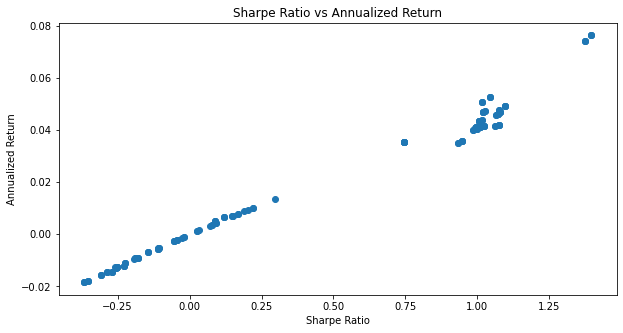

In [137]:
'''grid search for the best parameters'''
ticker1='^IXIC'

# ticker1='^DJI'
ticker2='^RUT'
# ticker2='^RUT'

#set parameters
stdate='2017-01-01'
eddate='2023-01-01'
training_window = 256
trading_period = 126
cop_types = [ 'clayton', 'frank', 'gumbel']


# weight_method = 'share'
#extract data
asset1=yf.download(ticker1,start=stdate,end=eddate)
asset2=yf.download(ticker2,start=stdate,end=eddate)  
# grid search
bound_signals = np.arange(0.35, 1.0, 0.05)
training_window_vols = [60, 126]
# bound_stop_losses = np.arange(1, 5, 2)
bound_stop_losses = [2,3,4]
trading_periods = [60]
training_windows = [126, 252]
# create a dataframe to store the performance of the portfolio
performances = pd.DataFrame()
for bound_signal in bound_signals:
    for bound_stop_loss in bound_stop_losses:
        for trading_period in trading_periods:
            for training_window in training_windows:
                for training_window_vol in training_window_vols:
                    print(bound_signal, bound_stop_loss, trading_period, training_window)
                    boundarys = [bound_signal, 0, bound_stop_loss]
                    signals, refitting_index_all, trading_periods_all = signal_generation_mc(asset1, asset2, training_window, trading_period, cop_types ,boundarys, training_window_vol)
                    portfolio, performance = backtest(signals, if_z = 0,weight_method = 'dollar')
                    sharpes = performance['sharpe_ratio'].values
                    annualized_returns = performance['annualized_return'].values
                    performances = performances.append({'bound_signal': bound_signal, 'bound_stop_loss': bound_stop_loss, 'trading_period': trading_period, 'traing_window':training_window,'training_window_vol':training_window_vol,'sharpe_ratio': sharpes, 'annualized_return':annualized_returns}, ignore_index=True)
                    print(performance)
performances.sort_values(by=['sharpe_ratio'], ascending=False)
performances.to_excel('data/performances_IXIC_RUT_change_window_5y.xlsx')
# plot the historical sharpe ratio and annualized return
plt.figure(figsize=(10,5))
plt.scatter(performances['sharpe_ratio'], performances['annualized_return'])
plt.xlabel('Sharpe Ratio')
plt.ylabel('Annualized Return')
plt.title('Sharpe Ratio vs Annualized Return')
plt.show()



In [ ]:
'''restore the portfolio given different parameters'''
import os
ticker1='^IXIC'

# ticker1='^DJI'
ticker2='^RUT'
# ticker2='^RUT'

#set parameters
stdate='2017-01-01'
eddate='2023-01-01'
training_window = 256
cop_types = [ 'clayton', 'frank', 'gumbel']


#extract data
asset1=yf.download(ticker1,start=stdate,end=eddate)
asset2=yf.download(ticker2,start=stdate,end=eddate)  
# grid search
bound_signals = np.arange(0.0, 1.0, 0.05)
training_window_vol = 126
# bound_stop_losses = np.arange(1, 5, 2)
bound_stop_loss = 2
trading_period = 60
training_windows = 252
# create a dataframe to store the performance of the portfolio
cumsums = pd.DataFrame()
root_path = 'data/params'
# for bound_signal in bound_signals:
#     boundarys = [bound_signal, 0, bound_stop_loss]
#     signals, refitting_index_all, trading_periods_all = signal_generation_mc(asset1, asset2, training_window, trading_period, cop_types ,boundarys, training_window_vol)
#     portfolio, performance = backtest(signals, if_z = 0,weight_method = 'dollar')
#     # add the portfolio['cum_ret'] to the cumsums dataframe as a new column
#     cumsums = pd.concat([cumsums, portfolio['cum_ret']], axis=1)
#     # rename the last column(the bound_signal keep 2 decimal)


#     cumsums.rename(columns={'cum_ret': 'bound_signal_{}'.format(round(bound_signal,2))}, inplace=True)

In [188]:
# '''restore the portfolio given different parameters'''
# import os
# ticker1='^IXIC'

# # ticker1='^DJI'
# ticker2='^RUT'
# # ticker2='^RUT'

# #set parameters
# stdate='2017-01-01'
# eddate='2023-01-01'
# training_window = 256
# cop_types = [ 'clayton', 'frank', 'gumbel']


# #extract data
# asset1=yf.download(ticker1,start=stdate,end=eddate)
# asset2=yf.download(ticker2,start=stdate,end=eddate)  
# # grid search
# bound_signals = np.arange(0.0, 1.0, 0.05)
# training_window_vol = 126
# # bound_stop_losses = np.arange(1, 5, 2)
# bound_stop_loss = 2
# trading_period = 60
# training_window = 252
# # create a dataframe to store the performance of the portfolio
# cumsums = pd.DataFrame()
# root_path = 'data/params'
# for bound_signal in bound_signals:
#     boundarys = [bound_signal, 0, bound_stop_loss]
#     signals, refitting_index_all, trading_periods_all = signal_generation_mc(asset1, asset2, training_window, trading_period, cop_types ,boundarys, training_window_vol)
#     portfolio, performance = backtest(signals, if_z = 0,weight_method = 'dollar')
#     # add the portfolio['cum_ret'] to the cumsums dataframe as a new column
#     cumsums = pd.concat([cumsums, portfolio['cum_ret']], axis=1)
#     # rename the last column(the bound_signal keep 2 decimal)


#     cumsums.rename(columns={'cum_ret': 'bound_signal_{}'.format(round(bound_signal,2))}, inplace=True)
# # remove the timezone
# # cumsums.index = cumsums.index.tz_localize(None)
# # cumsums.to_excel('data/diff_params_mc.xlsx')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
refitting the model at index 252
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 312
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 372
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 432
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 492
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 552
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 612
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 672
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 732
method: SLSQP

In [165]:
# cumsums.index = cumsums.index.tz_localize(None)
# cumsums.to_csv('data/diff_params_mc.csv')

In [16]:
# performances.sort_values(by=['sharpe_ratio'], ascending=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
refitting the model at index 252
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 312
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 372
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 432
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 492
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 552
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 612
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 672
method: SLSQP - success: True : Optimization terminated successfully
refitting the model at index 732
method: SLSQP

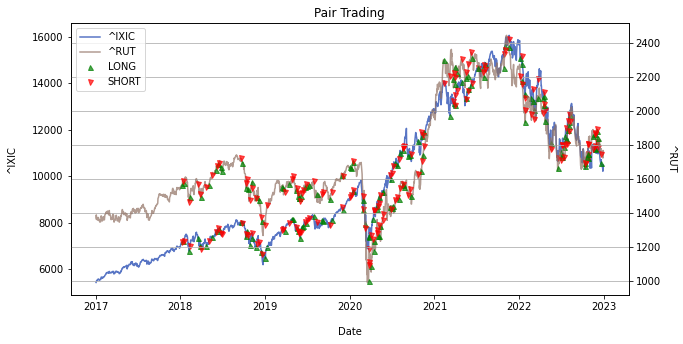

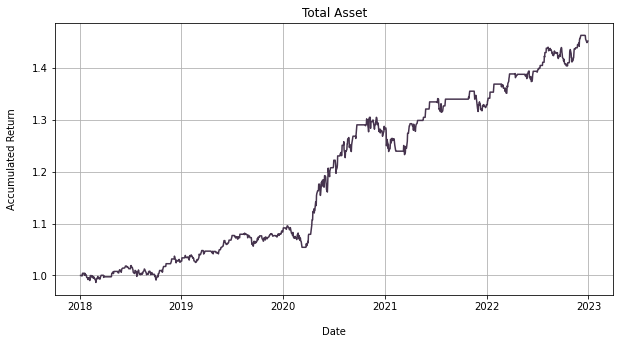

,sharpe_ratio,annualized_return,annualized_volatility,max_drawdown,win_rate,average_win,average_loss,profit_factor
0,1.39676,0.076311,0.054634,0.055163,0.535806,0.003401,-0.002877,0.845914


In [169]:
'''run the backtest'''
#set parameters
stdate='2017-01-01'
eddate='2023-01-01'
cop_types = [ 'clayton', 'frank', 'gumbel']

# cop_types = [ 'clayton','gumbel']

# ticker1='^DJT'
ticker1='^IXIC'
# ticker1='^NYA'
# ticker1='^GSPC'
# ticker2='^NDX'
ticker2='^RUT'
# ticker1='NFLX'
# ticker2='META'
asset1=yf.download(ticker1,start=stdate,end=eddate)
asset2=yf.download(ticker2,start=stdate,end=eddate)  
bound_signal = 0.35
bound_stop_loss = 2
trading_period = 60
training_window = 252
training_window_vol = 126
boundarys = [bound_signal, 0, bound_stop_loss]
signals, refitting_index_all, trading_periods_all  = signal_generation_mc(asset1, asset2, training_window, trading_period, cop_types ,boundarys,training_window_vol)
portfolio, performance = backtest(signals, if_z = 0,weight_method = 'dollar')
plot_price(signals,ticker1,ticker2) 
plot_portfolio(portfolio, signals, if_z = 0)
performance

<AxesSubplot: xlabel='Date'>

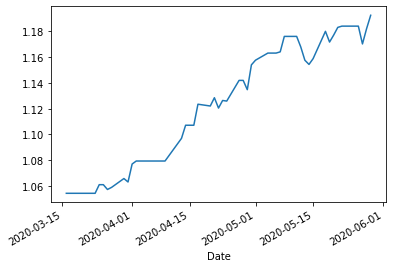

In [175]:
portfolio['cum_ret'].loc['2020-03-16':'2020-05'].plot()

In [40]:
signals['refitting_period'] = np.nan

In [48]:
signals['train_period'] = np.nan

In [72]:
def get_training_period(series):
    for i in range(len(trading_periods_all)):
        if series.name in trading_periods_all[i]:
            return i
signals['training_period']=signals.apply(get_training_period, axis=1)

In [64]:
signals['refitting_period'].fillna(method='ffill', inplace=True)

In [18]:
'''get the interval of the refitting index'''
refitting_intervals = []
for i in range(len(refitting_index_all)-1):
    refitting_intervals.append([refitting_index_all[i], refitting_index_all[i+1]])
refitting_intervals.append([refitting_index_all[-1], len(signals)])

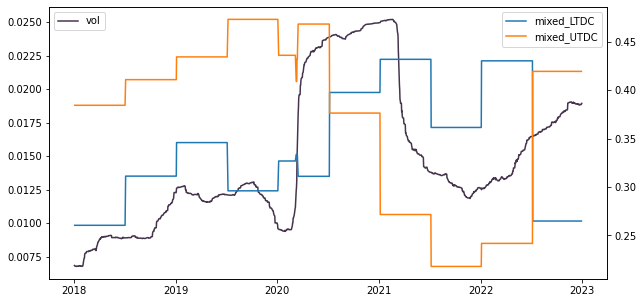

In [19]:
'''plot the weights of the portfolio and the price of the assets'''
# set 2 axes
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax2=ax.twinx()
# plot the price of the assets

# ax.plot(signals['asset1']/(signals['asset1'].iloc[0]),c='#46344e')
# ax.plot(signals['asset2']/(signals['asset2'].iloc[0]))
vix = df_closes['^VIX']
vix_rolling = vix.rolling(30).mean()
vol_rolling = (signals['asset1_vol'] + signals['asset2_vol'])/2
# ax.plot(vix_rolling.loc[signals.index])
ax.plot(vol_rolling.loc[signals.index],c='#46344e')
# ax.plot(vix.loc[signals.index])
# plot the weights of the portfolio
ax2.plot(signals.loc[:,['mixed_LTDC','mixed_UTDC']] )
# ax2.plot(signals.loc[:,'mixed_LTDC'] + signals.loc[:,'mixed_UTDC'] )
# ax2.plot(signals.loc[:,['mixed_LTDC']], c = 'r')

# ax2.plot(signals.loc[:,['mixed_LTDC']], c = 'r')
# set the legend
ax.legend(['vol'],loc='upper left')

ax2.legend(['mixed_LTDC','mixed_UTDC'],loc='upper right')



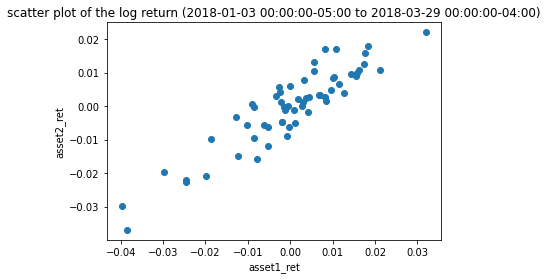

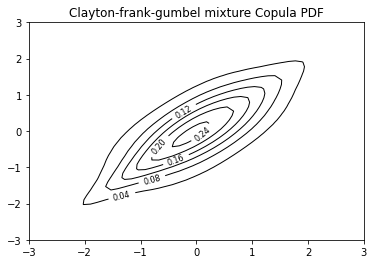

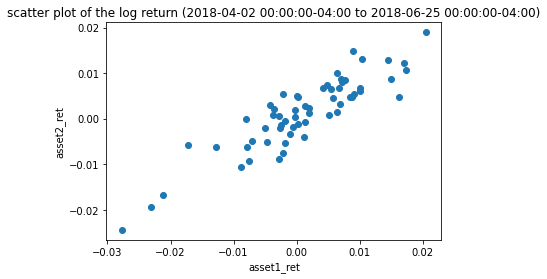

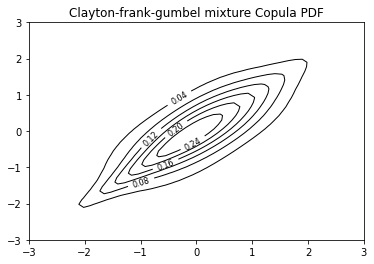

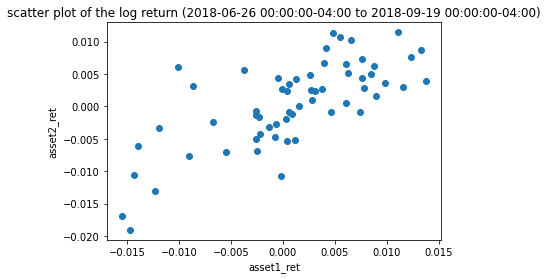

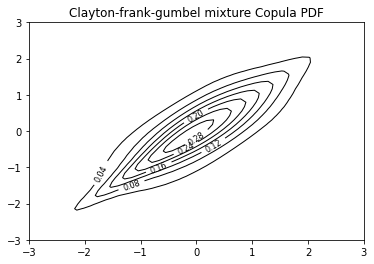

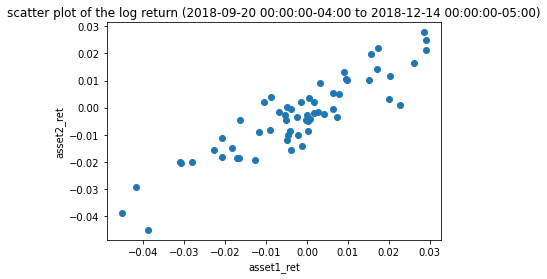

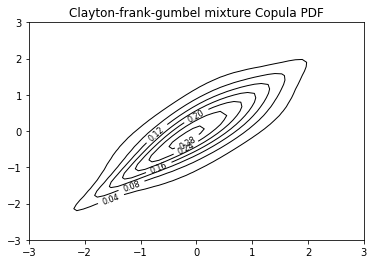

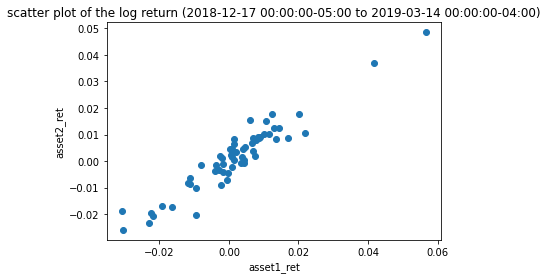

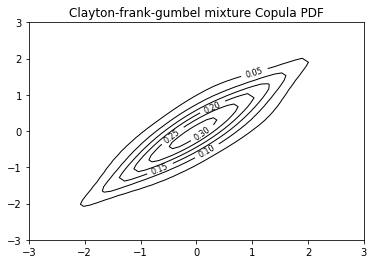

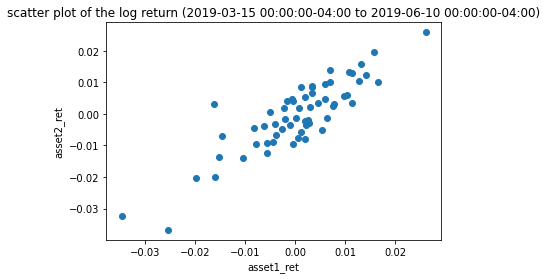

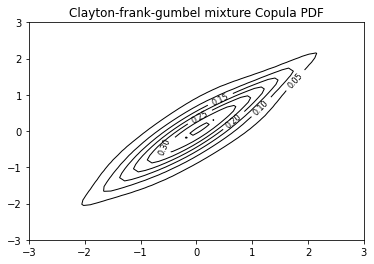

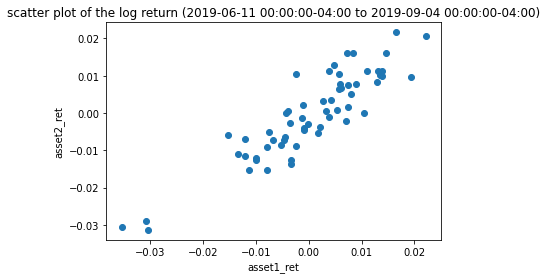

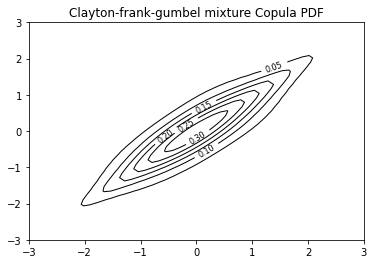

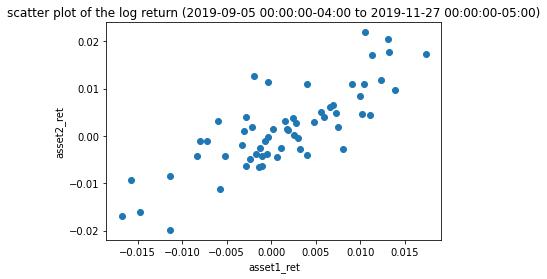

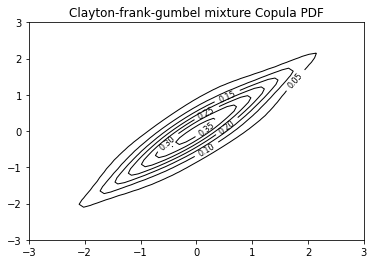

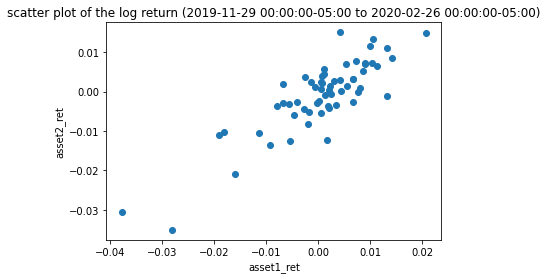

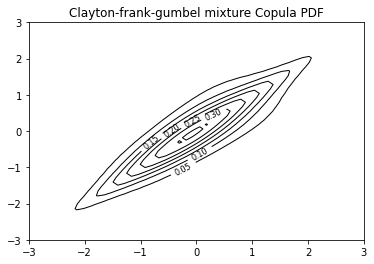

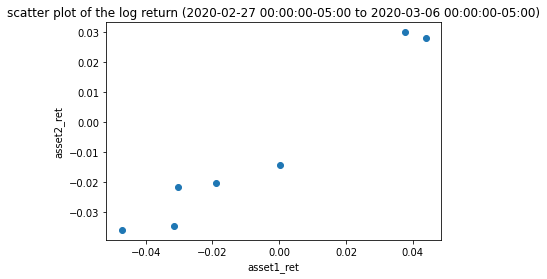

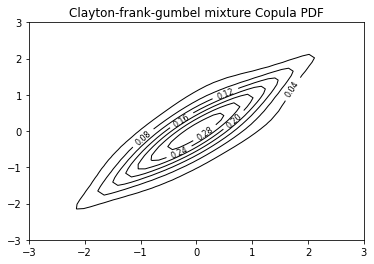

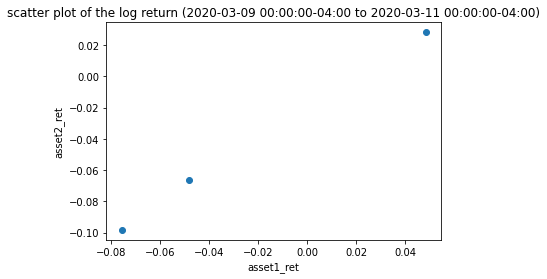

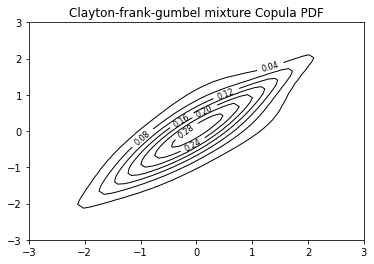

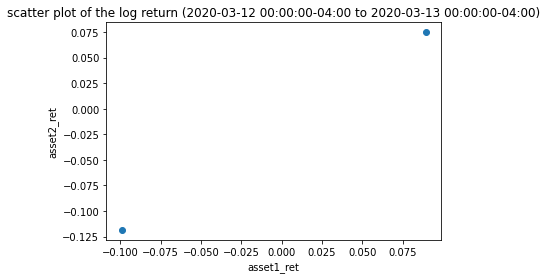

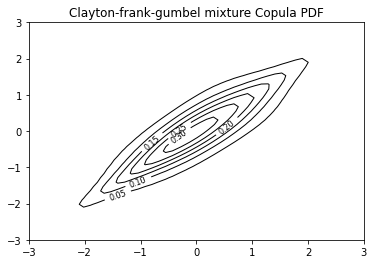

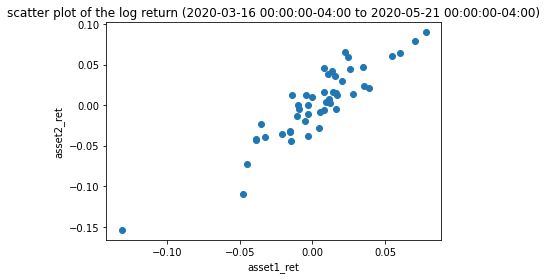

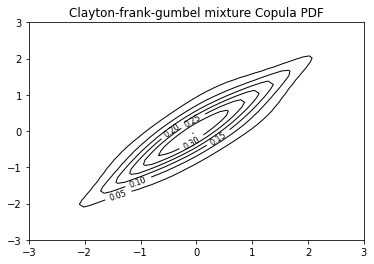

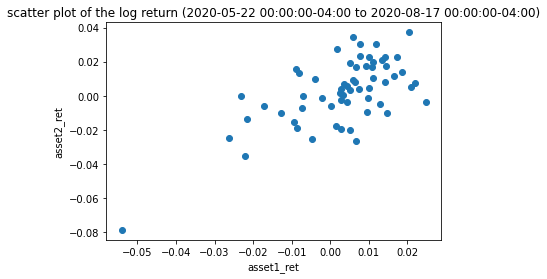

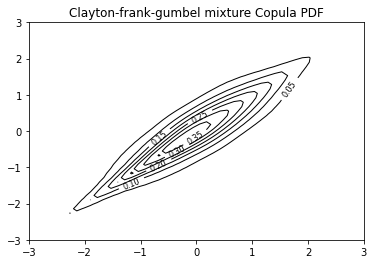

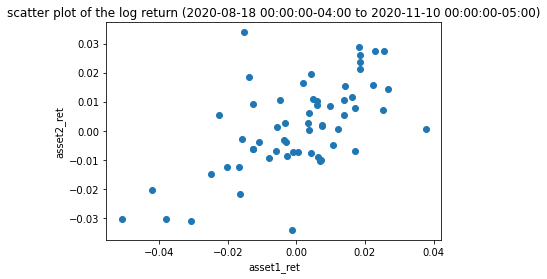

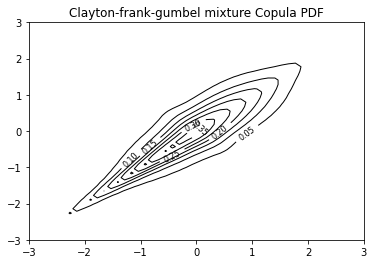

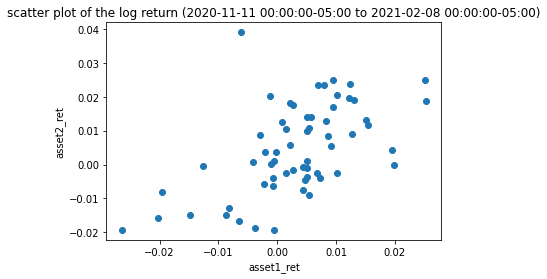

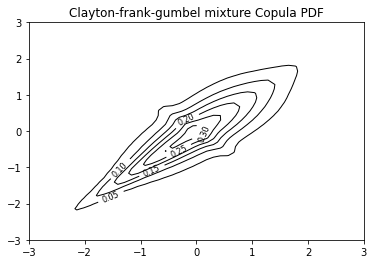

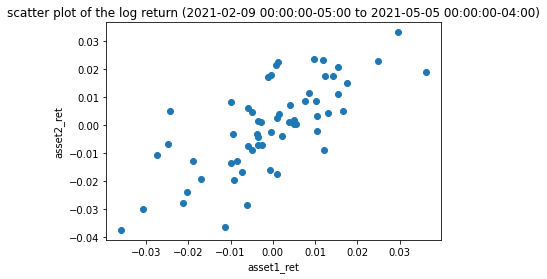

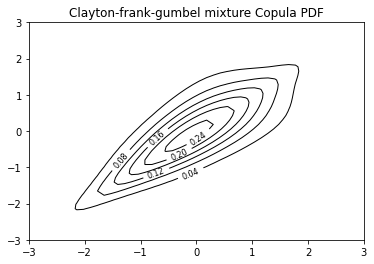

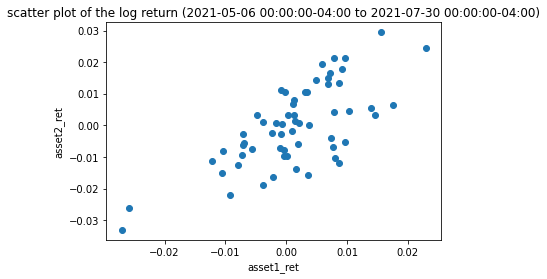

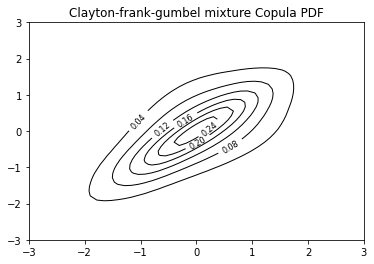

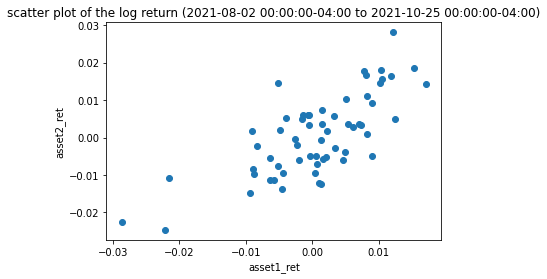

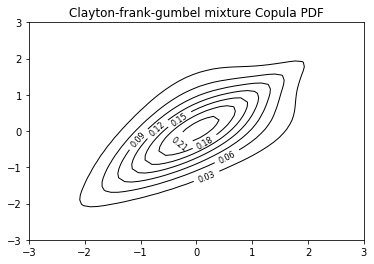

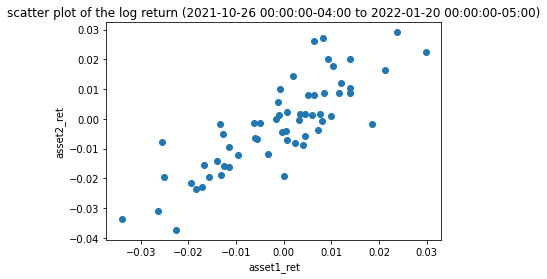

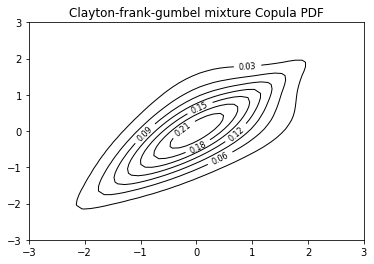

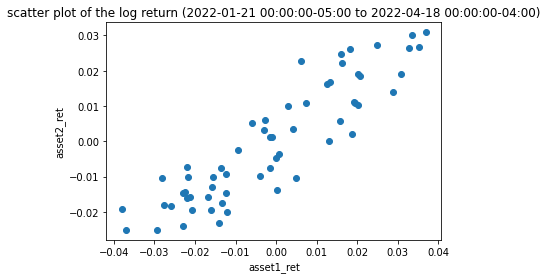

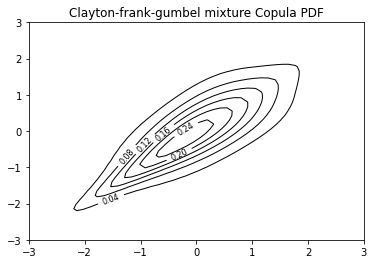

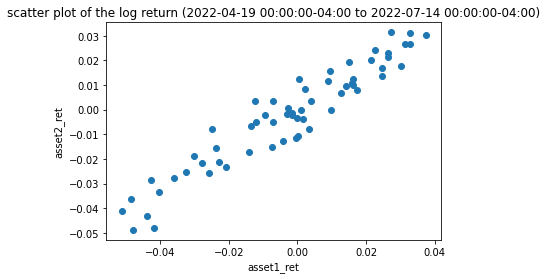

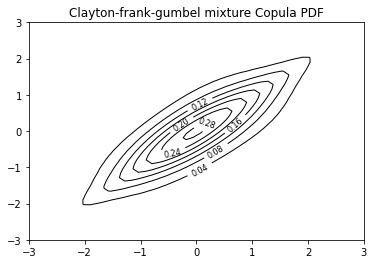

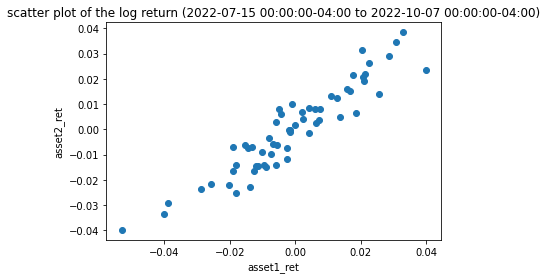

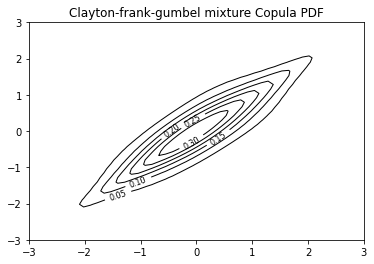

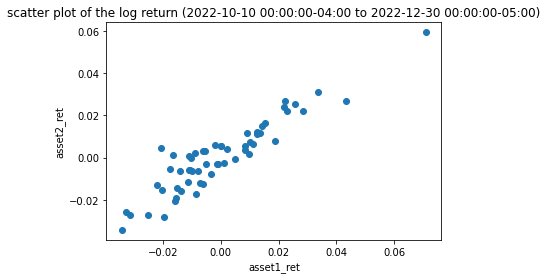

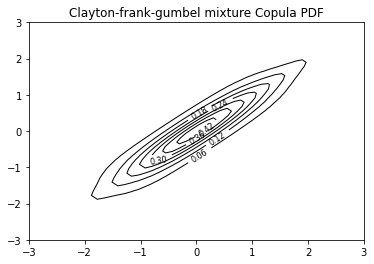

In [ ]:
# plot the log return scatter plot and the copula density(subplot of 2)
marginals = [
    {
        "distribution": norm, "loc" : 0, "scale" : 1,
    },
    {
        "distribution": norm, "loc" : 0, "scale": 1,
    }]
for refitting_interval in refitting_intervals:
    signals_refitting = signals.iloc[refitting_interval[0]:refitting_interval[1]]
    # if len(signals_refitting) < 5:
        # continue
    # create 2 subplots
    # plot the scatter plot of the log return
    plt.figure()
    plt.scatter(signals_refitting['asset1_ret'], signals_refitting['asset2_ret'])
    plt.xlabel('asset1_ret')
    plt.ylabel('asset2_ret')
    plt.title('scatter plot of the log return ({0} to {1})'.format(signals_refitting.index[0], signals_refitting.index[-1]))
    plt.show()
    
    # plot the copula density
    cop = mixture(["clayton","frank", "gumbel"])
    param = signals_refitting[['w_clayton','w_frank','w_gumbel','param_clayton','param_frank','param_gumbel']].iloc[0].to_list()
    cop.plot_mpdf(param, marginals, plot_type="contour", Nsplit=50)




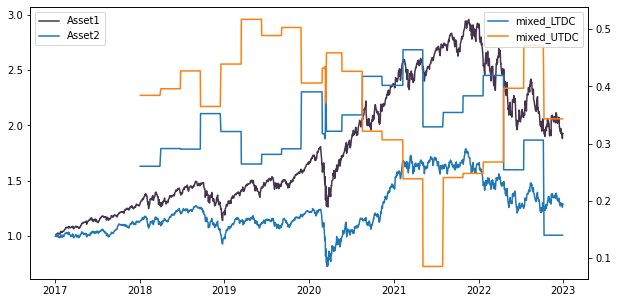

In [ ]:
'''plot the LTDC and UTDC and the price of the assets'''
# set 2 axes
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax2=ax.twinx()
# plot the price of the assets

ax.plot(signals['asset1']/(signals['asset1'].iloc[0]),c='#46344e')
ax.plot(signals['asset2']/(signals['asset2'].iloc[0]))
# plot the weights of the portfolio
ax2.plot(signals.loc[:,['mixed_LTDC','mixed_UTDC']])
# set the legend
ax.legend(['Asset1','Asset2'],loc='upper left')

ax2.legend(['mixed_LTDC','mixed_UTDC'],loc='upper right')

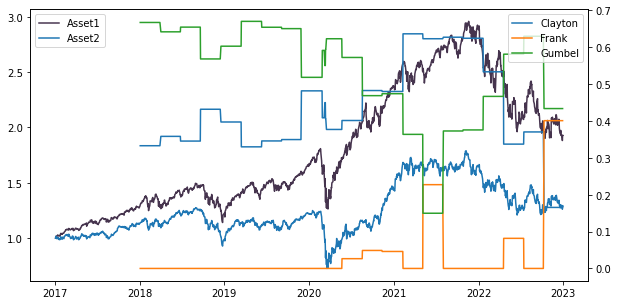

In [ ]:
'''plot the weights of the portfolio and the price of the assets'''
# set 2 axes
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax2=ax.twinx()
# plot the price of the assets

ax.plot(signals['asset1']/(signals['asset1'].iloc[0]),c='#46344e')
ax.plot(signals['asset2']/(signals['asset2'].iloc[0]))
# plot the weights of the portfolio
ax2.plot(signals.loc[:,['w_clayton','w_frank','w_gumbel']])
# set the legend
ax.legend(['Asset1','Asset2'],loc='upper left')

ax2.legend(['Clayton','Frank','Gumbel'],loc='upper right')

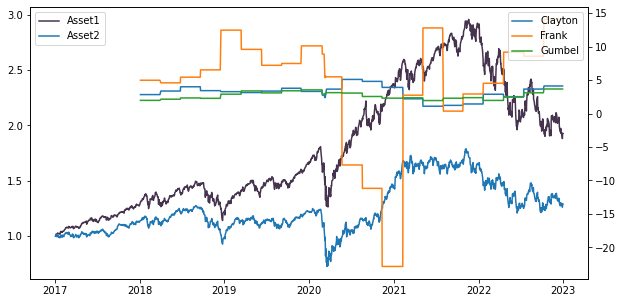

In [ ]:
'''plot the parameters of the copula'''
# set 2 axes
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
ax2=ax.twinx()
# plot the price of the assets

ax.plot(signals['asset1']/(signals['asset1'].iloc[0]),c='#46344e')
ax.plot(signals['asset2']/(signals['asset2'].iloc[0]))
# plot the weights of the portfolio
ax2.plot(signals.dropna().loc[:,['param_clayton','param_frank','param_gumbel']])
# set the legend
ax.legend(['Asset1','Asset2'],loc='upper left')

ax2.legend(['Clayton','Frank','Gumbel'],loc='upper right')


<AxesSubplot: xlabel='Date'>

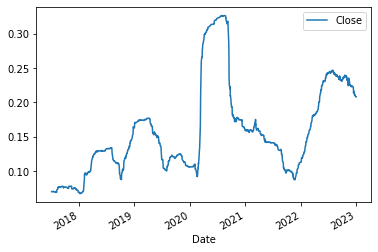

In [ ]:
'''plot the rolling volatility of the assets'''
rolling_volatility(asset1, 128).plot()